In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from swag import SWAG
from models import SimpleNet, ConvNN
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights

# Check functions validity

In [32]:
net = SimpleNet()
print(net)

SimpleNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [33]:
# Get params in 1D and the lookups
params_1d, shape_lookup, len_lookup = model_param_to_1D(net)

# Recover model_params
model_params = params_1d_to_weights(params_1d, shape_lookup, len_lookup)
train_weights = model_params[2].detach().numpy()

In [34]:
# Create new net with weights
new_net = create_NN_with_weights(SimpleNet, model_params)

# Test if the params are still the same
new_params = nn.ParameterList(new_net.parameters())
test_weights = new_params[2].detach().numpy()

assert np.all(test_weights == train_weights)

In [35]:
print(new_net)

SimpleNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# SWAG Training

In [36]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR


In [37]:
swag = SWAG(ConvNN, K = 2)

In [38]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


truck   car  frog   car


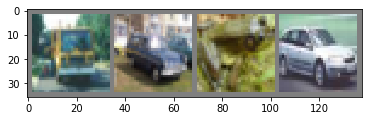

In [39]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))

In [40]:
# Compile swa

lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = CosineAnnealingLR
swa_scheduler = LambdaLR

swag.compile(lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

In [41]:
# Fit swag
first_mom, second_mom, D = swag.fit(trainloader,
                                    train_epoch=2,
                                    swag_epoch=2)

Begin NN model training:
[1,  2000] loss: 2.190
[1,  4000] loss: 1.864
[1,  6000] loss: 1.705
[1,  8000] loss: 1.617
[1, 10000] loss: 1.527
[1, 12000] loss: 1.444
[2,  2000] loss: 1.387
[2,  4000] loss: 1.337
[2,  6000] loss: 1.320
[2,  8000] loss: 1.333
[2, 10000] loss: 1.308
[2, 12000] loss: 1.251

Begin SWAG training:
[1,  2000] loss: 1.177
[1,  4000] loss: 1.201
[1,  6000] loss: 1.175
[1,  8000] loss: 1.166
[1, 10000] loss: 1.159
[1, 12000] loss: 1.170
[2,  2000] loss: 1.068
[2,  4000] loss: 1.070
[2,  6000] loss: 1.077
[2,  8000] loss: 1.048
[2, 10000] loss: 1.056
[2, 12000] loss: 1.065


In [42]:
first_mom.shape, second_mom.shape, D.shape


((62006,), (62006,), (62006, 2))

In [43]:
D.sum()

-58.50238164231121

In [46]:
D.shape

(62006, 2)

In [44]:
(second_mom-first_mom**2).sum()

7.231106847321823

In [45]:
# sample weights
weights = swag.weight_sampler(first_mom[0:100], second_mom[0:100], D[0:100,:], S=1)

[2.06526587e-03 2.02428407e-03 1.42268307e-03 4.71645777e-07
 8.20975579e-05 1.76136830e-03 3.89748363e-06 5.82148916e-03
 2.80720470e-03 9.66507445e-04 9.99467725e-04 4.66008459e-03
 2.03705850e-03 2.52608510e-04 2.88220024e-03 6.88619251e-04
 1.53876056e-03 6.10920298e-04 1.01657138e-03 1.29370601e-05
 1.00571039e-04 5.96218173e-04 2.66447876e-04 6.22490115e-04
 9.56419109e-04 5.83598210e-04 2.75394367e-03 1.94509287e-03
 5.68454578e-05 5.40620671e-05 3.30967699e-03 3.15758396e-04
 2.09915267e-03 8.37204923e-04 1.17826182e-03 2.19343810e-03
 1.75519620e-03 1.66208861e-04 1.65486138e-03 3.12521005e-03
 7.57174559e-05 2.49928236e-04 2.04840598e-03 2.59524640e-03
 6.36728379e-06 1.28495367e-04 8.35147842e-04 2.80771963e-04
 5.25253801e-04 6.55857593e-04 6.17038923e-03 7.04030100e-05
 3.34793359e-06 4.58322204e-04 1.12967210e-04 5.51166171e-04
 1.77514382e-04 4.08473762e-03 2.03595542e-03 1.76560020e-04
 1.04235374e-03 3.03955732e-03 5.97823832e-04 4.47295413e-04
 6.95851858e-04 2.241768

In [14]:
print(weights.shape)
swag.params_1d.shape

torch.Size([100])


(62006,)

In [15]:
swag.predict(testset, first_mom, second_mom, D, S=1)


AttributeError: 'CIFAR10' object has no attribute 'shape'